# Measuring the water level of Śniardwy lake in Poland

Natebook showcases an example of Earth observation processing chain that determines water levels of any water body (dam, reservoir, lake, ...) from satellite imagery. The entire processing chain is performed using the `eo-learn` package. The user simply needs to provide a polygon with water body's nominal water extent.

In [76]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Imports

In [77]:
# Do obsługi danych przestrzennych opisujących zasięg wód
import geopandas as gpd

# Import biblioteki matplotlib
import matplotlib.pyplot as plt

# Standardowe narzędzia do analizy danych numpy i matplotlib
import numpy as np

# Wczytywanie poligonu nominalnego zasięgu wód
import shapely.wkt

# Przetwarzanie obrazu 
# Nasz detektor wody będzie oparty na prostym progowaniu obrazu w skali szarości
# indeksu NDWI (Znormalizowany Indeks Różnicy Wodnej)
from skimage.filters import threshold_otsu

# sentinelhub-py - pobieranie danych satelitarnych Sentinel-2
from sentinelhub import CRS, BBox, DataCollection, SHConfig

# eo-learn - podstawowe komponenty
from eolearn.core import EOTask, EOWorkflow, FeatureType, OutputTask, linearly_connect_tasks

# Filtrowanie scen
from eolearn.features import NormalizedDifferenceIndexTask, SimpleFilterTask

# Rasteryzacja poligonu
from eolearn.geometry import VectorToRasterTask
from eolearn.io import SentinelHubInputTask

## Water level extraction EOWorkflow

Our basic logic of the example workflow is:

1. Download all available Sentinel-2 sattelite imagery of Theewaterskloof Dam from beginning of 2016 and today
    * We want to calculate NDWI and also have a true color visualization of the area. We need the following bands: 
        * B02, B03, B04 for `TRUE_COLOR` for visualisations
        * B03, B08 for NDWI calculation 
        * CLM (provided by Sentinel Hub) for cloud masking
2. Clouds are very often obscuring the view of the ground. In order to correctly determine the water level of the dam all images with clouds need to be filtered out. We will use the cloud masks provided by Sentinel Hub to filter clouds without the need for time consuming processing locally.
3. Apply adaptive thresholding to `NDWI` grayscale images
4. Extract water level from a comparison of measured water extent with the nominal one

Each step in the above overview of the workflow is accomplished by adding an `EOTask` to the `EOWorkflow`

In [78]:
# Konfigurator dostępu do Sentinel Hub 
from sentinelhub import SHConfig

config = SHConfig()
config.sh_client_id = "34c7cd40-3276-47a7-b32b-101f399dad05"
config.sh_client_secret = "DXkplvpqUGQ3r92KAnMSImXwMtRwam0y"
config.instance_id = "97487a7d-3752-46a8-afa9-73db8d72961f"
config.save()

### Load the Polygon of nominal water extent and define a `BBox`

The `BBox` defines an area of interest and will be used to create an EOPatch.

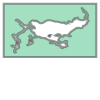

In [79]:
# Poligon zapory jest zapisany w formacie WKT oraz w układzie współrzędnych WGS84
with open("map.wkt", "r") as f:
    dam_wkt = f.read()

dam_nominal = shapely.wkt.loads(dam_wkt)

# Zwiększ obszar (granice) BBOX
inflate_bbox = 0.1
minx, miny, maxx, maxy = dam_nominal.bounds

delx = maxx - minx
dely = maxy - miny
minx = minx - delx * inflate_bbox
maxx = maxx + delx * inflate_bbox
miny = miny - dely * inflate_bbox
maxy = maxy + dely * inflate_bbox

dam_bbox = BBox([minx, miny, maxx, maxy], crs=CRS.WGS84)

dam_bbox.geometry - dam_nominal

### Step 1: Intialize (and implement workflow specific) EOTasks

#### Create an EOPatch and add all EO features (satellite imagery data)

In [80]:
download_task = SentinelHubInputTask(
    data_collection=DataCollection.SENTINEL2_L1C,
    bands_feature=(FeatureType.DATA, "BANDS"),
    resolution=20,
    maxcc=0.5,
    bands=["B02", "B03", "B04", "B08"],
    additional_data=[(FeatureType.MASK, "dataMask", "IS_DATA"), (FeatureType.MASK, "CLM")],
    cache_folder="cached_data",
)

calculate_ndwi = NormalizedDifferenceIndexTask((FeatureType.DATA, "BANDS"), (FeatureType.DATA, "NDWI"), (1, 3))

#### Burn in the nominal water extent

The `VectorToRaster` task expects the vectorised dataset in geopandas dataframe.

In [81]:
dam_gdf = gpd.GeoDataFrame(crs=CRS.WGS84.pyproj_crs(), geometry=[dam_nominal])

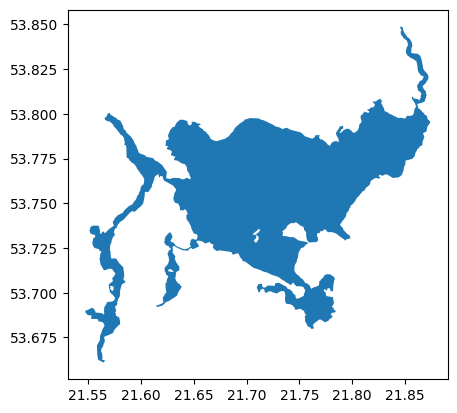

In [82]:
dam_gdf.plot();

In [83]:
add_nominal_water = VectorToRasterTask(
    dam_gdf,
    (FeatureType.MASK_TIMELESS, "NOMINAL_WATER"),
    values=1,
    raster_shape=(FeatureType.MASK, "IS_DATA"),
    raster_dtype=np.uint8,
)

#### The cloud mask is already provided by Sentinel Hub, we use it to calulcate the valid data mask. 

Define a `VALID_DATA` layer: pixel has to contain data and should be classified as clear sky by the cloud detector (`CLM` equals 0)

In [84]:
class AddValidDataMaskTask(EOTask):
    def execute(self, eopatch):
        is_data_mask = eopatch[FeatureType.MASK, "IS_DATA"].astype(bool)
        cloud_mask = ~eopatch[FeatureType.MASK, "CLM"].astype(bool)
        eopatch[FeatureType.MASK, "VALID_DATA"] = np.logical_and(is_data_mask, cloud_mask)
        return eopatch


add_valid_mask = AddValidDataMaskTask()

Calculate fraction of valid pixels per frame and store it as `SCALAR` feature

In [85]:
def calculate_coverage(array):
    return 1.0 - np.count_nonzero(array) / np.size(array)


class AddValidDataCoverageTask(EOTask):
    def execute(self, eopatch):
        valid_data = eopatch[FeatureType.MASK, "VALID_DATA"]
        time, height, width, channels = valid_data.shape

        coverage = np.apply_along_axis(calculate_coverage, 1, valid_data.reshape((time, height * width * channels)))

        eopatch[FeatureType.SCALAR, "COVERAGE"] = coverage[:, np.newaxis]
        return eopatch


add_coverage = AddValidDataCoverageTask()

Filter out too cloudy scenes. We filter out all observation which have cloud coverage of more than 5%. 


In [86]:
cloud_coverage_threshold = 0.05


class ValidDataCoveragePredicate:
    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, array):
        return calculate_coverage(array) < self.threshold


remove_cloudy_scenes = SimpleFilterTask(
    (FeatureType.MASK, "VALID_DATA"), ValidDataCoveragePredicate(cloud_coverage_threshold)
)

#### Apply Water Detection



In [87]:
class WaterDetectionTask(EOTask):
    @staticmethod
    def detect_water(ndwi):
        """Very simple water detector based on Otsu thresholding method of NDWI."""
        otsu_thr = 1.0
        if len(np.unique(ndwi)) > 1:
            ndwi[np.isnan(ndwi)] = -1
            otsu_thr = threshold_otsu(ndwi)

        return ndwi > otsu_thr

    def execute(self, eopatch):
        water_masks = np.asarray([self.detect_water(ndwi[..., 0]) for ndwi in eopatch.data["NDWI"]])

        # Interesuje nas tylko woda znajdująca się w granicach zapory
        water_masks = water_masks[..., np.newaxis] * eopatch.mask_timeless["NOMINAL_WATER"]

        water_levels = np.asarray(
            [np.count_nonzero(mask) / np.count_nonzero(eopatch.mask_timeless["NOMINAL_WATER"]) for mask in water_masks]
        )

        eopatch[FeatureType.MASK, "WATER_MASK"] = water_masks
        eopatch[FeatureType.SCALAR, "WATER_LEVEL"] = water_levels[..., np.newaxis]

        return eopatch


water_detection = WaterDetectionTask()

### Step 2: Define the EOWorkflow

In [88]:
# Aby uzyskać dostęp do końcowych danych, używamy OutputTask
output_task = OutputTask("final_eopatch")


workflow_nodes = linearly_connect_tasks(
    download_task,
    calculate_ndwi,
    add_nominal_water,
    add_valid_mask,
    add_coverage,
    remove_cloudy_scenes,
    water_detection,
    output_task,
)
workflow = EOWorkflow(workflow_nodes)

### Step 3: Run the workflow

Process all Sentinel-2 acquisitions from beginning of 2016 and until beginning of June 2020.

In [89]:
time_interval = ["2019-01-01", "2020-06-01"]

In [90]:
# Zadanie pobierania wymaga podania dodatkowych parametrów podczas jego uruchamiania. Parametry te są powiązane z węzłem, w którym zadanie jest wykonywane
download_node = workflow_nodes[0]

result = workflow.execute(
    {
        download_node: {"bbox": dam_bbox, "time_interval": time_interval},
    }
)

Print content of eopatch at the end of the workflow execution

In [91]:
patch = result.outputs["final_eopatch"]
patch

EOPatch(
  data={
    BANDS: numpy.ndarray(shape=(35, 1267, 1279, 4), dtype=float32)
    NDWI: numpy.ndarray(shape=(35, 1267, 1279, 1), dtype=float32)
  }
  mask={
    CLM: numpy.ndarray(shape=(35, 1267, 1279, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(35, 1267, 1279, 1), dtype=bool)
    VALID_DATA: numpy.ndarray(shape=(35, 1267, 1279, 1), dtype=bool)
    WATER_MASK: numpy.ndarray(shape=(35, 1267, 1279, 1), dtype=uint8)
  }
  scalar={
    COVERAGE: numpy.ndarray(shape=(35, 1), dtype=float64)
    WATER_LEVEL: numpy.ndarray(shape=(35, 1), dtype=float64)
  }
  mask_timeless={
    NOMINAL_WATER: numpy.ndarray(shape=(1267, 1279, 1), dtype=uint8)
  }
  meta_info={
    maxcc: 0.5
    size_x: 1279
    size_y: 1267
    time_difference: 1.0
    time_interval: ('2019-01-01T00:00:00', '2020-06-01T23:59:59')
  }
  bbox=BBox(((21.514725477430904, 53.64218082682358), (21.90638563368098, 53.867677571615204)), crs=CRS('4326'))
  timestamp=[datetime.datetime(2019, 1, 23, 9, 55, 38), ..., datetim

# Plot results

In [92]:
# Importujemy filtr Sobela do wykrywania krawędzi oraz funkcje morfologiczne - closing i disk - któe pozwalają na przetwarzanie obrazów
from skimage.filters import sobel
from skimage.morphology import closing, disk

In [93]:
# Funckja wyświetlana obraz RGB z eopatcha dla wskazanego indeksu, nakładając na niego morfologicznie przetworzone maski wody - nominalną zaznaczoną na czerwono i obserwowaną na niebiesko - aby wizualnie porównach ich granice
def plot_rgb_w_water(eopatch, idx):
    ratio = np.abs(eopatch.bbox.max_x - eopatch.bbox.min_x) / np.abs(eopatch.bbox.max_y - eopatch.bbox.min_y)
    fig, ax = plt.subplots(figsize=(ratio * 10, 10))

    ax.imshow(np.clip(2.5 * eopatch.data["BANDS"][..., [2, 1, 0]][idx], 0, 1))

    observed = closing(eopatch.mask["WATER_MASK"][idx, ..., 0], disk(1))
    nominal = sobel(eopatch.mask_timeless["NOMINAL_WATER"][..., 0])
    observed = sobel(observed)
    nominal = np.ma.masked_where(~nominal.astype(bool), nominal)
    observed = np.ma.masked_where(~observed.astype(bool), observed)

    ax.imshow(nominal, cmap=plt.cm.Reds)
    ax.imshow(observed, cmap=plt.cm.Blues)
    ax.axis("off")

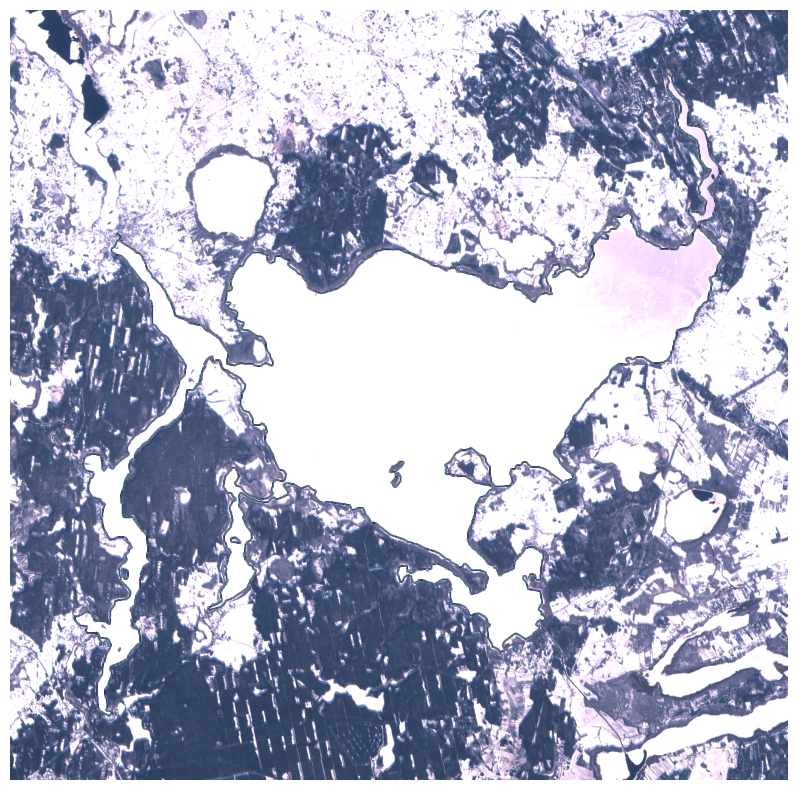

In [94]:
# Wyświetla obraz RGB z maskami wody dla pierwszego zestawu danych
plot_rgb_w_water(patch, 0)

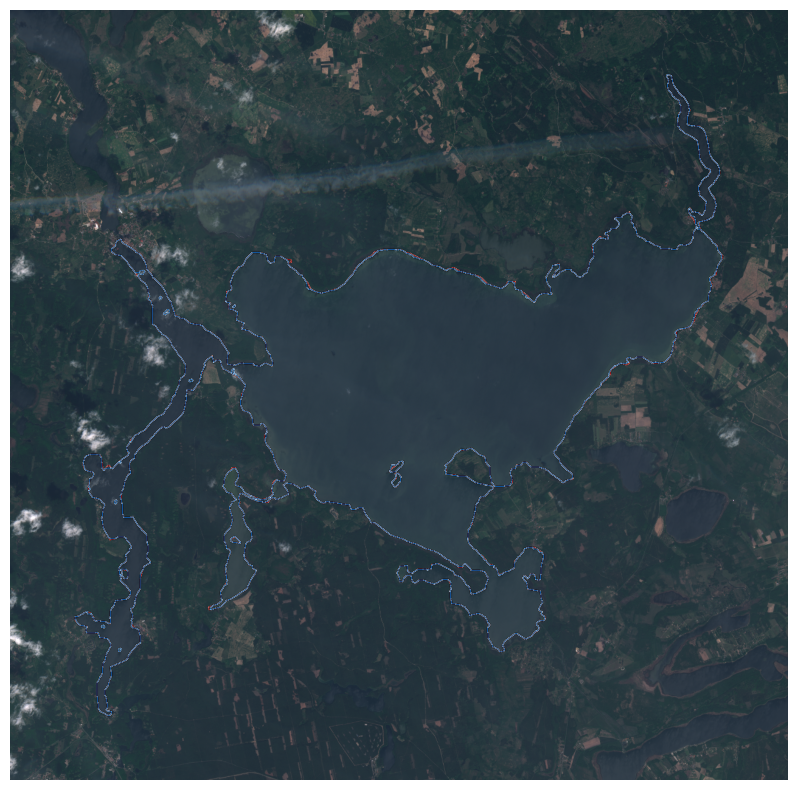

In [95]:
# Wyświetla obraz RGB z maskami wody dla ostatniego zestawu danych
plot_rgb_w_water(patch, -1)

In [96]:
# Funckcja tworzy wykres poziomów wody oraz pokrycia powierzchni wodnej w czasie, filtrując dane według maksymalnej wartości pokrycia, aby przedstawić zmiany na wybranym obszarze.
def plot_water_levels(eopatch, max_coverage=1.0):
    fig, ax = plt.subplots(figsize=(20, 7))

    dates = np.asarray(eopatch.timestamp)
    ax.plot(
        dates[eopatch.scalar["COVERAGE"][..., 0] < max_coverage],
        eopatch.scalar["WATER_LEVEL"][eopatch.scalar["COVERAGE"][..., 0] < max_coverage],
        "bo-",
        alpha=0.7,
    )
    ax.plot(
        dates[eopatch.scalar["COVERAGE"][..., 0] < max_coverage],
        eopatch.scalar["COVERAGE"][eopatch.scalar["COVERAGE"][..., 0] < max_coverage],
        "--",
        color="gray",
        alpha=0.7,
    )
    ax.set_ylim(0.0, 1.1)
    ax.set_xlabel("Date")
    ax.set_ylabel("Water level")
    ax.set_title("Sniadrwy Water Levels")
    ax.grid(axis="y")
    return ax

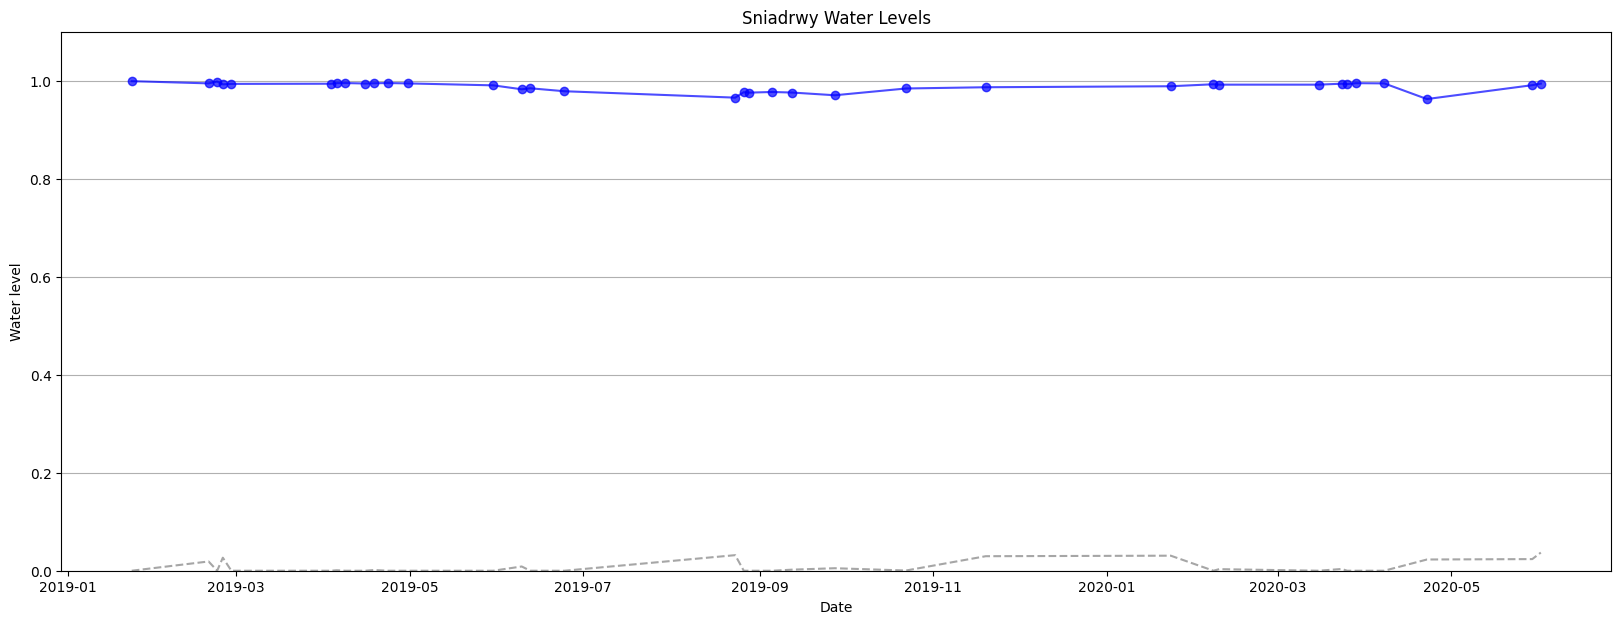

In [97]:
# Tworzy i wyświetla wykres poziomów wody oraz pokrycia powierzchni wodnej dla całego zakresu danych w eopatchu
ax = plot_water_levels(patch, 1.0)

Obliczanie stężenia chlorofilu w wodzie

In [98]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, r2_score

In [99]:
# Zadanie obliczania NDVI: (NIR - RED)/(NIR + RED), kanały B08 i B04
calculate_ndvi = NormalizedDifferenceIndexTask(
    (FeatureType.DATA, "BANDS"),
    (FeatureType.DATA, "NDVI"),
    (3, 2),  # indeksy kanałów: B08=3, B04=2 (licząc od 0)
)

# NDWI - wykorzystujemy pasma B03 (Green) i B08 (NIR)
calculate_ndwi = NormalizedDifferenceIndexTask(
    (FeatureType.DATA, "BANDS"),
    (FeatureType.DATA, "NDWI"),
    (1, 3)  # indeksy B03=1, B08=3 (licząc od 0)
)

In [100]:
# Output task do odbioru wyników
output_task = OutputTask("final_eopatch")

In [101]:
# Łączenie zadań w workflow
workflow_nodes = linearly_connect_tasks(
    download_task,
    calculate_ndwi,    # dodaj NDWI
    calculate_ndvi,    # dodaj NDVI
    output_task,
)
workflow = EOWorkflow(workflow_nodes)

In [102]:
# Wykonanie workflow
download_node = workflow_nodes[0]
result = workflow.execute({download_node: {"bbox": dam_bbox, "time_interval": time_interval}})

In [103]:
# Zapisuje do patch końcowy eopatch z wyników działania procesu
patch = result.outputs["final_eopatch"]

In [104]:
# 2. Wyciągnij obrazy NDWI i NDVI z patcha
ndwi = patch.data["NDWI"][0, ..., 0]  # kształt: (wys, szer)
ndvi = patch.data["NDVI"][0, ..., 0]  # kształt: (wys, szer)

# 3. Użyj NDWI jako maski wody (np. prog > 0 oznacza wodę)
water_mask = ndwi > 0

In [105]:
# 4. Przygotuj dane do ML — tylko piksele wody
features = patch.data["BANDS"][0][water_mask]  # wartości pasm Sentinel-2 dla pikseli wody, shape: (N,4)
labels = ndvi[water_mask]  # odpowiadające NDVI dla pikseli wody, shape: (N,)

In [106]:
# 5. Podziel na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# 6. Utwórz i wytrenuj model regresji
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [107]:
# 7. Ewaluacja modelu
y_pred = model.predict(X_test)
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.4f}")
print(f"R^2 Score: {r2_score(y_test, y_pred):.4f}")

Mean Squared Error: 0.0000
R^2 Score: 0.9995


In [108]:
# 8. Predykcja NDVI (chlorofilu) na całym obszarze wodnym w wybranym czasie
all_pixels = patch.data["BANDS"][0].reshape(-1, 4)  # wszystkie piksele w scenie
predicted_ndvi = model.predict(all_pixels).reshape(patch.data["BANDS"].shape[1], patch.data["BANDS"].shape[2])

# 9. Zastosuj maskę - wyczyść poza wodą
predicted_ndvi[~water_mask] = np.nan

In [109]:
# Funkcja do rysowania wykresu NDVI w czasie (średnia wartość po pikselach)
def plot_chlorophyll_levels(eopatch):
    dates = np.asarray(eopatch.timestamp)
    ndvi_data = eopatch.data["NDVI"]  # shape: (time, height, width, 1)
    mean_ndvi = ndvi_data[..., 0].mean(axis=(1, 2))  # średnia po przestrzeni (wys, szer)

    plt.figure(figsize=(16, 6))
    plt.plot(dates, mean_ndvi, "g^-", alpha=0.7, label="Mean NDVI (chlorophyll proxy)")
    plt.xlabel("Date")
    plt.ylabel("NDVI")
    plt.title("Chlorophyll Proxy (NDVI) over Time")
    plt.grid(True)
    plt.legend()
    plt.show()

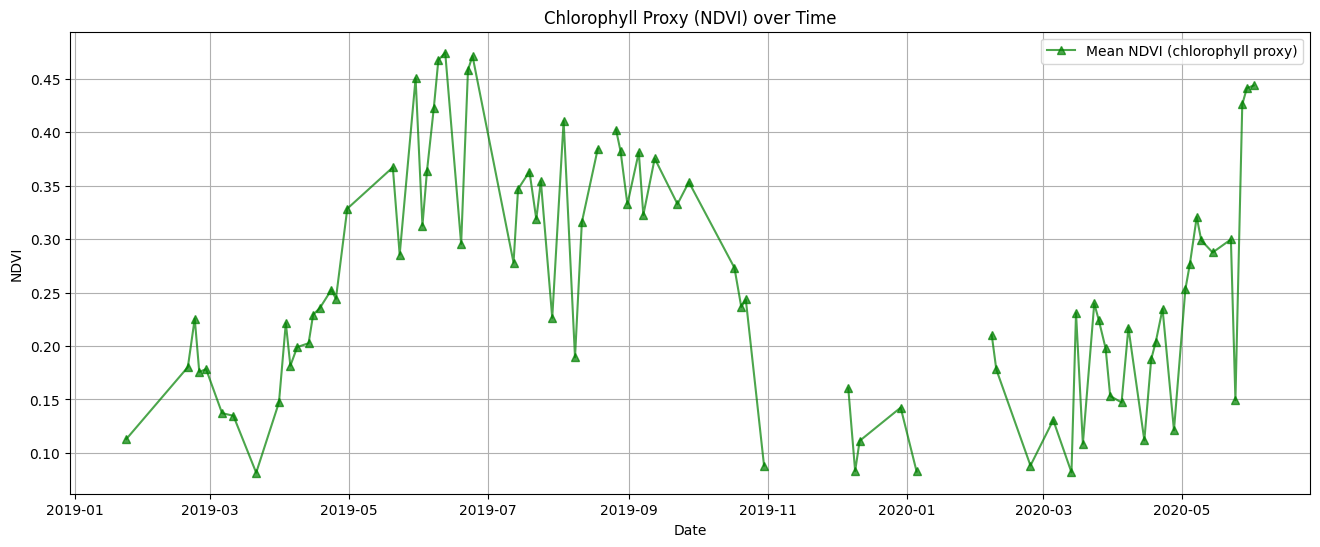

In [110]:
# Wywołanie funkcji rysującej wykres
plot_chlorophyll_levels(patch)

In [111]:
def plot_predicted_ndvi_map(predicted_ndvi, water_mask, timestamp):
    plt.figure(figsize=(8, 8))
    display_map = np.copy(predicted_ndvi)
    display_map[~water_mask] = np.nan
    plt.imshow(display_map, cmap="viridis")
    plt.colorbar(label="Predykcja NDVI (chlorofil)")
    plt.title(f"Predykcja NDVI na wodzie - data: {timestamp.date()}")
    plt.axis("off")
    plt.show()

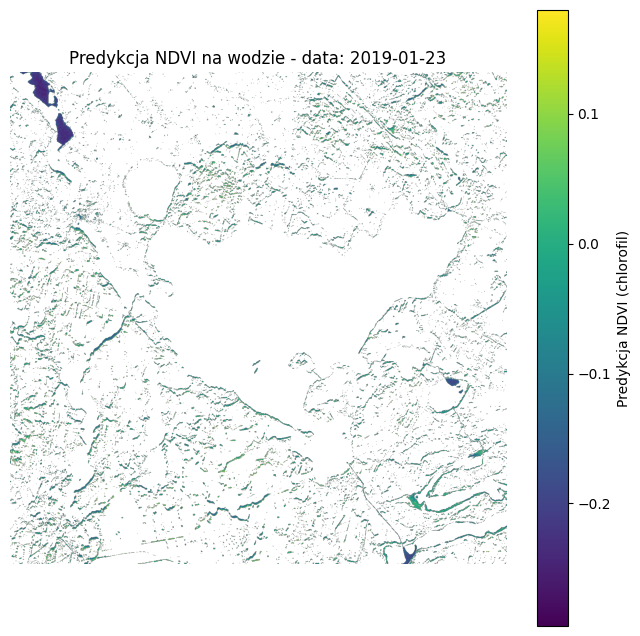

In [112]:
plot_predicted_ndvi_map(predicted_ndvi, water_mask, patch.timestamp[0])

In [113]:
def plot_actual_vs_predicted(y_true, y_pred):
    plt.figure(figsize=(7, 7))
    plt.scatter(y_true, y_pred, alpha=0.5, edgecolors='k')
    min_val = min(np.min(y_true), np.min(y_pred))
    max_val = max(np.max(y_true), np.max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.xlabel("Rzeczywiste NDVI")
    plt.ylabel("Predykowane NDVI")
    plt.title("Regresja NDVI na wodzie - Rzeczywiste vs Predykowane")
    plt.grid(True)
    plt.show()

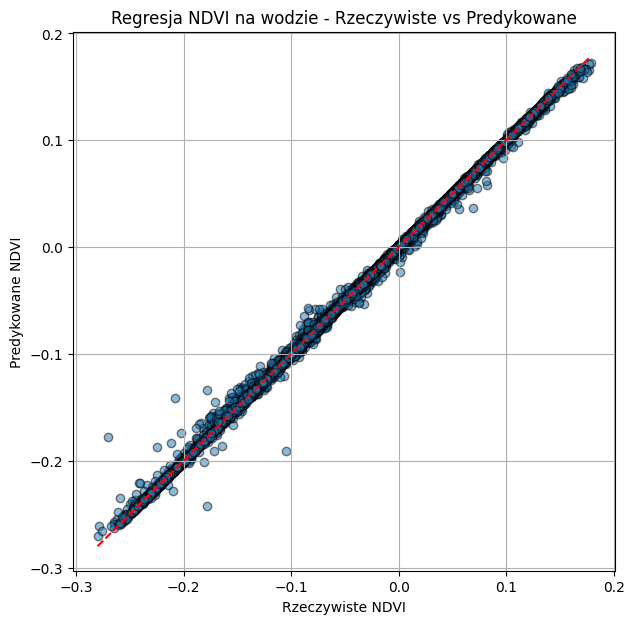

In [114]:
plot_actual_vs_predicted(y_test, y_pred)